# fast gradient sign method (fgsm)
- goal: create $x_{fgsm}$ that is close to $x$ and leads to misclassification
- $x_{fgsm}=x - sign(\frac{\partial f(x)_{y}}{\partial x})) \cdot \epsilon$
- $sign(\frac{\partial f(x)_{y}}{\partial x})):$ direction in which score for class $y$, increases

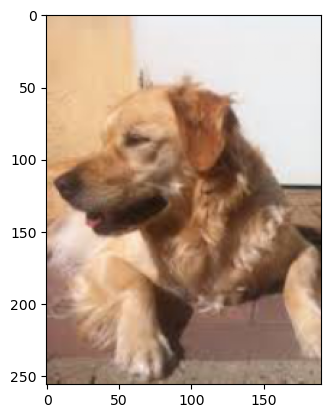

In [1]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Compose, ToTensor, Resize
import torch
from PIL import Image
import matplotlib.pyplot as plt

# load data and model
trans = Compose([Resize(256), ToTensor()])
img = Image.open("../../data/imagenet/dog_cat.jpeg")
x0 = torch.nn.Parameter(torch.unsqueeze(trans(img), dim=0)[:, :, :, :190])
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
softmax = torch.nn.Softmax(dim=0)
plt.imshow(x0[0].permute(1, 2, 0).detach())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


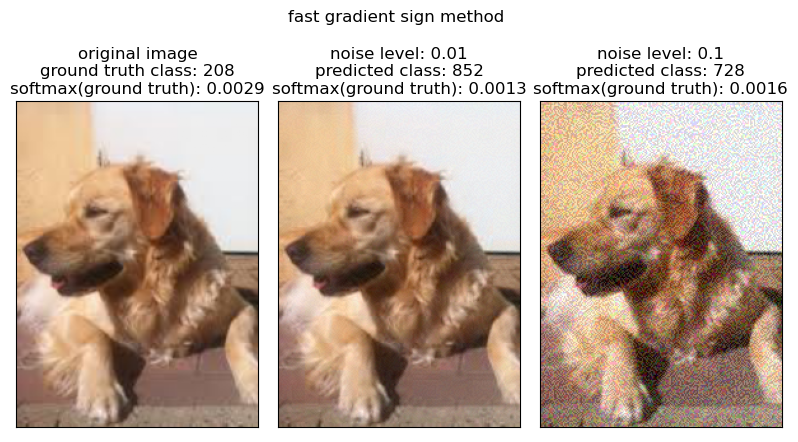

In [2]:
scores = resnet(x0)[0]
cls_id_x0 = torch.argmax(scores)
softmax_score_x0 = softmax(scores)[cls_id_x0].item()

scores[cls_id_x0].backward()
img_grad_sign = torch.sign(x0.grad)  # direction in which class score increases

softmax_scores = []
cls_ids = []
x = []
noise_levels = [0.01, 0.1]
for noise_level in noise_levels:
    with torch.no_grad():
        x_pert = x0 - noise_level * img_grad_sign
        scores = resnet(x_pert)[0]
        cls_ids.append(torch.argmax(scores).item())
        softmax_score = softmax(scores)[cls_id_x0]
        softmax_scores.append(softmax_score.item())
        x.append(x_pert)

fig, axs = plt.subplots(nrows=1, ncols=len(x) + 1, figsize=(8, 5))
fig.suptitle("fast gradient sign method")

# original image
x0_title = f"original image\nground truth class: {cls_id_x0}\nsoftmax(ground truth): {round(softmax_score_x0, 4)}"
axs[0].imshow(x0[0].detach().permute(1, 2, 0))
axs[0].set_title(x0_title)
axs[0].set_xticks([])
axs[0].set_yticks([])

# augmented images
for i in range(len(x)):
    title = f"noise level: {noise_levels[i]}\npredicted class: {cls_ids[i]}\nsoftmax(ground truth): {round(softmax_scores[i], 4)}"
    axs[i + 1].imshow(x[i][0].detach().permute(1, 2, 0))
    axs[i + 1].set_title(title)
    axs[i + 1].set_xticks([])
    axs[i + 1].set_yticks([])
plt.tight_layout()
plt.savefig("../../monitoring/carlini_wagner/fgsm.png")

# conclusions
- invisible (1%) perturbation leads to misclassification
- gradient is only a local approximation, so softmax score could even increase for strong perturbations